In [11]:
import pandas as pd
import openai
from tqdm import tqdm
from sacrebleu import BLEU, CHRF, TER
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from auxiliary import gpt_promt
tqdm.pandas()

openai.api_key_path = "../openai_endpoints/.api_key"

## Validate the tuned models and compare them to untuned counterparts

In [17]:
flint_model = "ft:gpt-3.5-turbo-1106:dsp-project::8hHiGRcA"
dpcl_model = "ft:gpt-3.5-turbo-1106:dsp-project::8hIXYrQs"

In [18]:
validation = pd.read_csv("validation.csv")

In [19]:
ARGS = {"temperature": 0.6, "max_tokens": 512}

def get_resonses(row):
    flint_msg = gpt_promt(row["text"], target="flint", testing=True)["message"]
    dpcl_msg = gpt_promt(row["text"], target="dcpl", testing=True)["message"]
    
    """The untuned gpt 3.5 model responses."""
    row["dpcl_primitive"] = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-1106",
            messages=dpcl_msg,
            **ARGS
        )
    
    row["flint_primitive"] = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-1106",
            messages=flint_msg,
            **ARGS
        )
    
    """The tuned gpt 3.5 model responses."""
    row["dpcl_tuned"] = openai.ChatCompletion.create(
            model=dpcl_model,
            messages=dpcl_msg,
            **ARGS
        )
    
    row["flint_tuned"] = openai.ChatCompletion.create(
            model=flint_model,
            messages=flint_msg,
            **ARGS
        )
    
    return row

In [20]:
validation = validation.progress_apply(get_resonses, axis=1)

100%|██████████| 30/30 [04:43<00:00,  9.44s/it]


In [26]:
validation.to_csv("validation_filled.csv")

## Process Data

In [16]:
def _extract_message(elem):
    msg = elem["choices"][0]["message"]["content"]
    return msg
def extract_all_messages(row):
    row["dpcl_primitive"] = _extract_message(row["dpcl_primitive"])
    row["dpcl_tuned"] = _extract_message(row["dpcl_tuned"])
    row["flint_primitive"] = _extract_message(row["flint_primitive"])
    row["flint_tuned"] = _extract_message(row["flint_tuned"])
    return row

In [ ]:
validation = validation.apply(extract_all_messages, axis=1)

## Compute Metrics

In [70]:
bleu = BLEU(effective_order=True)
chrf = CHRF()
ter = TER()

def _compute_bleu(row, target, ref):
    row[f"bleu_{target}"] = bleu.sentence_score(row[target], [row[ref]]).score
    return row
def _compute_chrf(row, target, ref):
    row[f"chrf_{target}"] = chrf.corpus_score(row[target], [row[ref]]).score
    return row
def _compute_ter(row, target, ref):
    row[f"ter_{target}"] = ter.sentence_score(row[target], [row[ref]]).score
    return row
    

def compute_metrics(row):
    row["length"] = len(row["text"])
    for target, ref in zip(["dpcl_primitive", "dpcl_tuned", "flint_primitive", "flint_tuned"], ["dcpl", "dcpl", "flint", "flint"]):
        row = _compute_bleu(row, target, ref)
        row = _compute_chrf(row, target, ref)
        row = _compute_ter(row, target, ref)
    return row

In [ ]:
validation_metric = validation.progress_apply(compute_metrics, axis=1)

## Plot Data

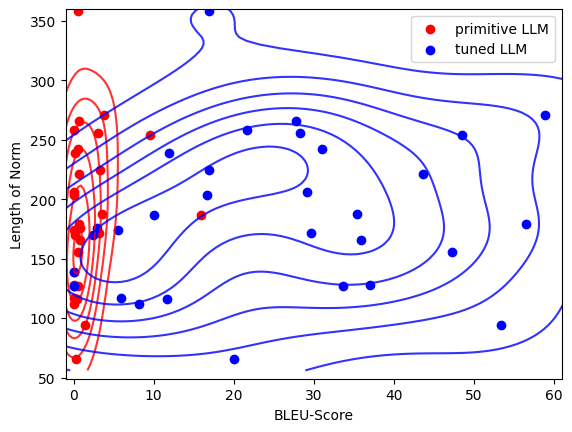

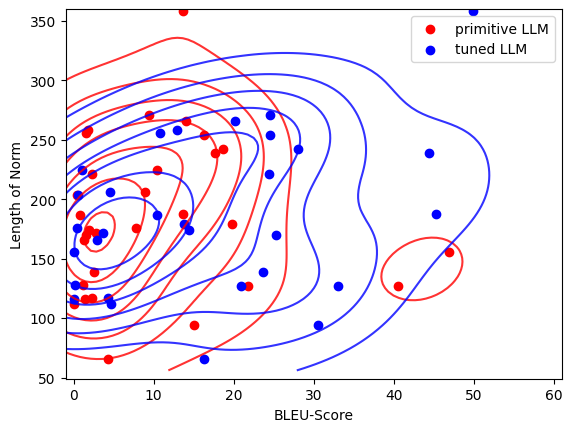

In [58]:
colors = ["r", "b"]
for elem in ["dpcl", "flint"]:
    fig, ax=plt.subplots(1, 1)
    
    ax.set_ylabel("Length of Norm")
    ax.set_xlabel("BLEU-Score")
    ax.set_ylim([49, 360])
    ax.set_xlim([-1, 61])
    
    y_list = validation_metric["length"].values.tolist()
    for i, tpe in enumerate(["primitive", "tuned"]):
        x_list = validation_metric[f"bleu_{elem}_{tpe}"].values.tolist()

        # Calculate kernel density estimate for z
        xy = np.vstack([x_list, y_list])
        z = stats.gaussian_kde(xy)(xy)
        
        x_grid, y_grid = np.mgrid[min(x_list)-10:max(x_list)+10:100j, min(y_list)-10:max(y_list)+10:100j] 
        positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
        z_grid = np.reshape(stats.gaussian_kde(xy)(positions), x_grid.shape)
        
        cp = ax.contour(x_grid, y_grid, z_grid, colors=colors[i], alpha=0.8)
        ax.scatter(x_list, y_list,color=colors[i], label=f"{tpe} LLM")
        
    plt.legend()
    plt.savefig(f"figures/{elem}_contour_bleu.png", dpi=200)



## Get Statistics

In [72]:
cols = [col for col in validation_metric.columns if any([x in col for x in ["bleu", "ter", "chrf"]])]
validation_metric[cols].mean()

bleu_dpcl_primitive       1.697739
chrf_dpcl_primitive       4.179282
ter_dpcl_primitive      101.164760
bleu_dpcl_tuned          24.901198
chrf_dpcl_tuned           5.584767
ter_dpcl_tuned           99.065031
bleu_flint_primitive     10.016322
chrf_flint_primitive      5.192532
ter_flint_primitive     120.811064
bleu_flint_tuned         16.520404
chrf_flint_tuned          8.716323
ter_flint_tuned         116.927605
dtype: float64

In [73]:
validation_metric[cols].std()

bleu_dpcl_primitive       3.342270
chrf_dpcl_primitive       1.966936
ter_dpcl_primitive       28.687551
bleu_dpcl_tuned          17.602868
chrf_dpcl_tuned           2.898527
ter_dpcl_tuned           40.248125
bleu_flint_primitive     11.468239
chrf_flint_primitive      1.571903
ter_flint_primitive     136.805399
bleu_flint_tuned         14.528943
chrf_flint_tuned          5.598902
ter_flint_tuned          99.817010
dtype: float64

In [77]:
# T-Testing
for method in ["dpcl", "flint"]:
    for metric in ["ter", "bleu", "chrf"]:
        t = stats.ttest_ind(
            validation_metric[f"{metric}_{method}_tuned"].values.tolist(),
            validation_metric[f"{metric}_{method}_primitive"].values.tolist(),
            alternative="less" if metric == "ter" else "greater",
        )
        print(f"{method}, {metric}: {t}")
    

dpcl, ter: TtestResult(statistic=-0.23268703493241316, pvalue=0.40841180233573465, df=58.0)
dpcl, bleu: TtestResult(statistic=7.093153852957365, pvalue=1.0221861775077471e-09, df=58.0)
dpcl, chrf: TtestResult(statistic=2.1976539609451167, pvalue=0.015990124452346457, df=58.0)
flint, ter: TtestResult(statistic=-0.1256018921478717, pvalue=0.4502407143179885, df=58.0)
flint, bleu: TtestResult(statistic=1.9246250879539364, pvalue=0.029593083534649494, df=58.0)
flint, chrf: TtestResult(statistic=3.318892061258583, pvalue=0.0007827760835411377, df=58.0)
